In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model


#to plot within notebook
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

import tensorflow as tf
print('Configurando TF')
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

look_back = 100
forward_days = 30
num_periods = 20

/home/benayas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/benayas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/benayas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/benayas/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

Configurando TF


In [2]:
#Get the data and splits in input X and output Y, by spliting in `n` past days as input X 
#and `m` coming days as Y.
def processData(data, look_back, forward_days,jump=1,  scale=True):
    X,Y = [],[]
    for i in range(0,len(data) -look_back -forward_days +1, jump):
        d = data[i:i+look_back+forward_days]
        if scale == True:
            d = MinMaxScaler().fit_transform( d )
        X.append(d[:look_back])
        Y.append(d[look_back:look_back+forward_days])
    return np.array(X),np.array(Y)
    
def plot_error(hist):
    pyplot.plot(hist['loss'])
    pyplot.plot(hist['val_loss'])
    pyplot.legend(['train', 'validation'], loc='upper left')

# Entrenar modelo AAPL

In [3]:
df_train = pd.read_feather("/home/benayas/datasets/lstm/train/train.feather")
appl = df_train[df_train['SYMBOL']=='AAPL']
array = appl['ADJ_CLOSE'].values.reshape(appl.shape[0],1)

In [4]:
# Normalize data and compile model

X,y = processData(array,look_back,forward_days)
y = np.array([list(a.ravel()) for a in y])
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.10, random_state=42)

#Training the LSTM
NUM_NEURONS_FirstLayer = 50
NUM_NEURONS_SecondLayer = 30
EPOCHS = 20

#Build the model
model = Sequential()
model.add(LSTM(NUM_NEURONS_FirstLayer,input_shape=(look_back,1), return_sequences=True))
model.add(LSTM(NUM_NEURONS_SecondLayer,input_shape=(NUM_NEURONS_FirstLayer,1)))
model.add(Dense(forward_days))
model.compile(loss='mean_squared_error', optimizer='adam')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
# Entrenar el modelo
history = model.fit(X_train,y_train,epochs=EPOCHS,validation_data=(X_validate,y_validate),shuffle=True,batch_size=2, verbose=1)

Train on 7839 samples, validate on 872 samples
Epoch 1/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0205 - val_loss: 0.0179
Epoch 2/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0191 - val_loss: 0.0176
Epoch 3/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0184 - val_loss: 0.0199
Epoch 4/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0179 - val_loss: 0.0168
Epoch 5/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0166 - val_loss: 0.0160
Epoch 6/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0165 - val_loss: 0.0158
Epoch 7/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0161 - val_loss: 0.0156
Epoch 8/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0156 - val_loss: 0.0177
Epoch 9/20
7839/7839 [==============================] - 653s 83ms/sample - loss: 0.0154 - val_los

In [ ]:
plot_error(history)

# Test

In [3]:
# Cargar datos test
df_test = pd.read_feather("/home/benayas/datasets/lstm/test/test.feather")
appl_test = df_test[df_test['SYMBOL']=='AAPL']
array_test = appl_test['ADJ_CLOSE'].values.reshape(appl_test.shape[0],1)

X_test,y_test = processData(array_test,look_back,forward_days, jump=num_periods, scale=False)

In [4]:
print('X shape {0}'.format(X_test.shape))
print('Y shape {0}'.format(y_test.shape))

X shape (22, 100, 1)
Y shape (22, 30, 1)


## Test con modelo entrenado en 1 valor (AAPL)

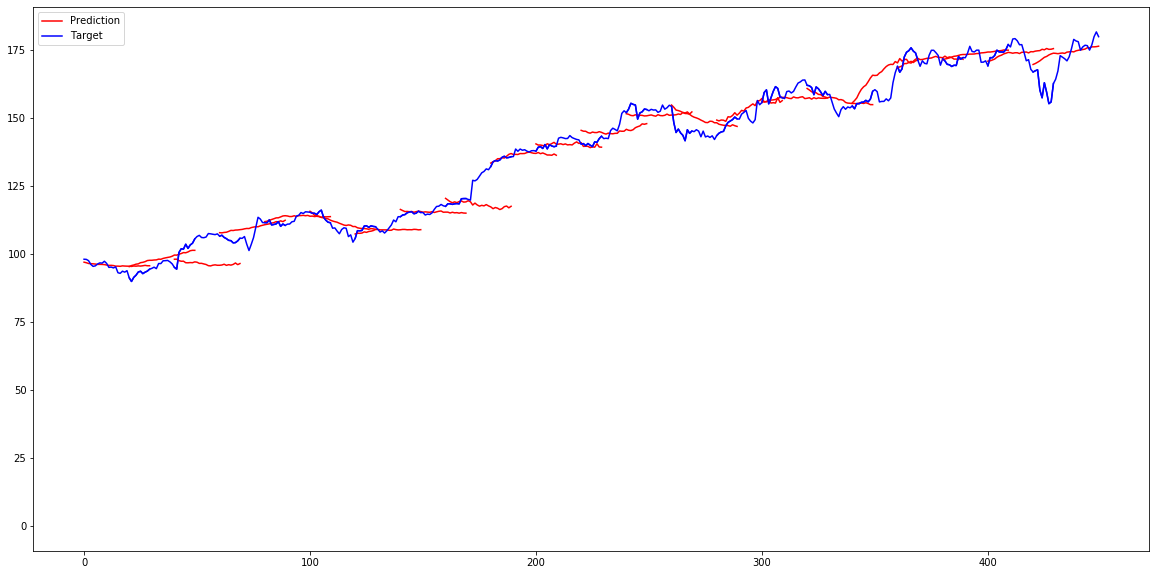

In [8]:
plt.figure(figsize = (20,10))

for i in range(0,len(X_test)):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    y_pred = model.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    #plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    plt.plot([x + i*num_periods for x in range(len(y_pred))], scl.inverse_transform(y_pred.reshape(-1,1)), color='r')
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='b')

plt.plot(0, 0, color='r', label='Prediction') #only to place the label
plt.plot(0,0,color='b', label='Target')
plt.legend(loc='best')
plt.show()

## Test con modelo entrenado en todos los valores

In [6]:
# Cargar modelo entrenado con todo
model_all = load_model("/home/benayas/results/best_lstm_test_all_balanced.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


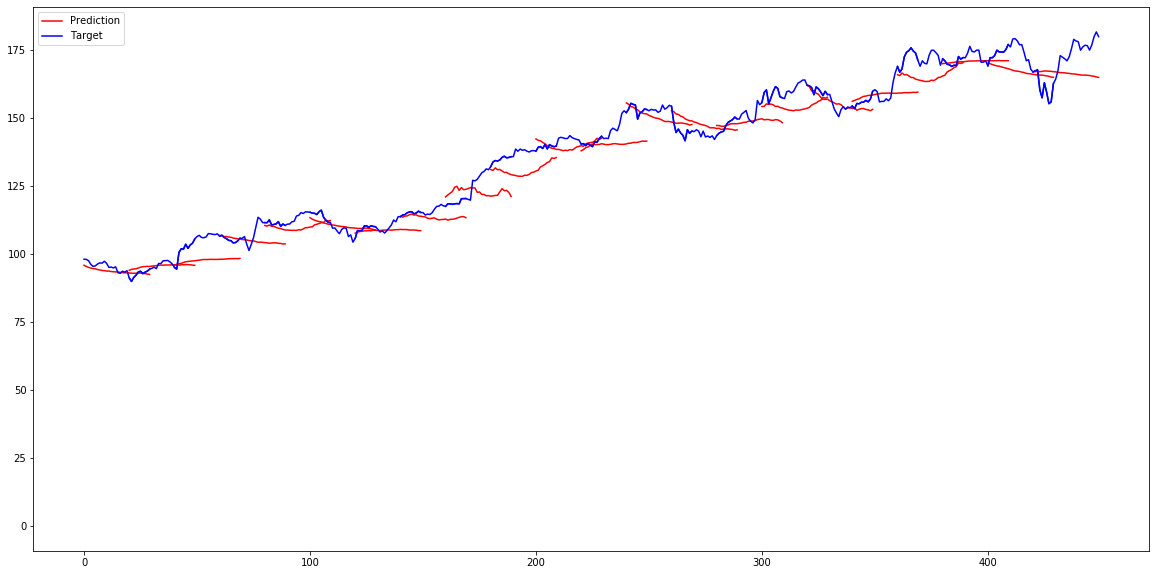

In [7]:
plt.figure(figsize = (20,10))

for i in range(0,len(X_test)):
    scl = MinMaxScaler()
    scl.fit(X_test[i])
    scl.fit(y_test[i])
    d = scl.transform( X_test[i] )
    y_pred = model_all.predict( d.reshape(1,d.shape[0],1) )
    y_pred = y_pred.reshape(-1,1)
    #plt.plot([x + i*forward_days for x in range(len(Xt[i]))], scl.inverse_transform(Xt[i].reshape(-1,1)), color='r')
    plt.plot([x + i*num_periods for x in range(len(y_pred))], scl.inverse_transform(y_pred.reshape(-1,1)), color='r')
    plt.plot([x + i*num_periods for x in range(len(y_test[i]))], y_test[i], color='b')

plt.plot(0, 0, color='r', label='Prediction') #only to place the label
plt.plot(0,0,color='b', label='Target')
plt.legend(loc='best')
plt.show()

## Test de predicción individual

In [10]:
Xt = model.predict(X_test)
Xt.shape

(22, 30)

In [12]:
i=0
scl = MinMaxScaler()
scl.fit(X_test[i])
scl.fit(y_test[i])
d = scl.transform( X_test[i] )
y_pred = model.predict( d.reshape(1,d.shape[0],1) )
y_pred = y_pred.reshape(-1,1)


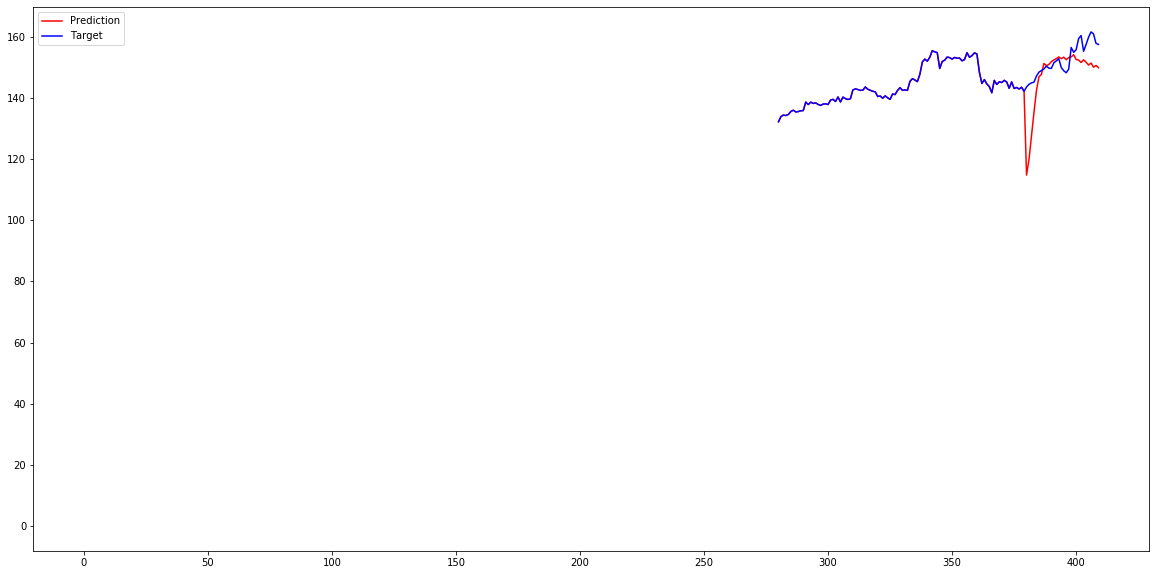

In [25]:
plt.figure(figsize = (20,10))
i=14
scl = MinMaxScaler()
scl.fit(X_test[i])
scl.fit(y_test[i])
d = scl.transform( X_test[i] )
y_pred = model.predict( d.reshape(1,d.shape[0],1) )
y_pred = y_pred.reshape(-1,1)
y_pred = scl.inverse_transform(y_pred.reshape(-1,1))
y_pred = np.concatenate([X_test[i],y_pred])

y_test2 = np.concatenate([X_test[i],y_test[i]])

plt.plot([x + i*num_periods for x in range(len(y_pred))], y_pred, color='r')
plt.plot([x + i*num_periods for x in range(len(y_test2))], y_test2, color='b')

plt.plot(0, 0, color='r', label='Prediction') #only to place the label
plt.plot(0, 0 ,color='b', label='Target')
plt.legend(loc='best')
plt.show()

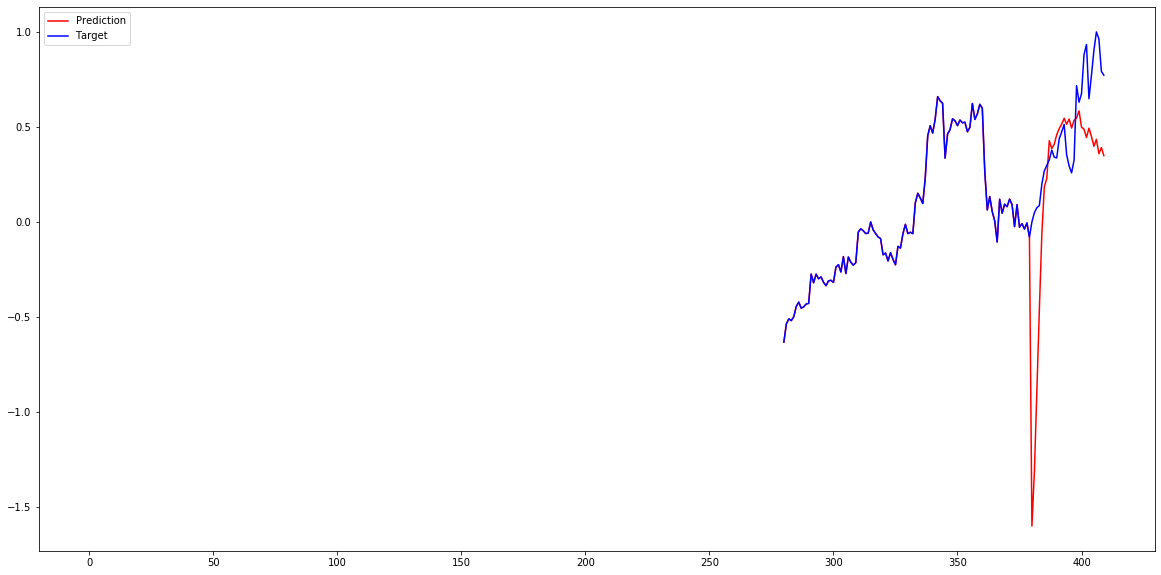

In [26]:
plt.figure(figsize = (20,10))
i=14
scl = MinMaxScaler()
scl.fit(X_test[i])
scl.fit(y_test[i])
d = scl.transform( X_test[i] ) # escalado a [0,1]
y_pred = model.predict( d.reshape(1,d.shape[0],1) )
y_pred = y_pred.reshape(-1,1)
#y_pred = scl.inverse_transform(y_pred.reshape(-1,1))
y_pred = np.concatenate([d,y_pred])
y_test2 = np.concatenate([d,scl.transform( y_test[i] )])

plt.plot([x + i*num_periods for x in range(len(y_pred))], y_pred, color='r')
plt.plot([x + i*num_periods for x in range(len(y_test2))], y_test2, color='b')

plt.plot(0, 0, color='r', label='Prediction') #only to place the label
plt.plot(0, 0 ,color='b', label='Target')
plt.legend(loc='best')
plt.show()